# Anchor explanations for ImageNet

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from alibi.datasets import imagenet
from alibi.explainers import AnchorImage

Using TensorFlow backend.


### Load InceptionV3 model pre-trained on ImageNet

In [2]:
model = InceptionV3(weights='imagenet')

### Download and preprocess some images from ImageNet

The *imagenet* function takes as arguments one of the following ImageNet categories: 'Persian cat', 'volcano', 'strawberry', 'jellyfish' or 'centipede' as well as the number of images to return and the target size of the image.

In [3]:
category = 'Persian cat'
image_shape = (299, 299, 3)
data, labels = imagenet(category, nb_images=10, target_size=image_shape[:2], seed=2)
print('Images shape: {}'.format(data.shape))

Images shape: (10, 299, 299, 3)


Apply image preprocessing, make predictions and map predictions back to categories. The output label is a tuple which consists of the class name, description and the prediction probability.

In [4]:
images = preprocess_input(data)
preds = model.predict(images)
label = decode_predictions(preds, top=3)
print(label[0])

[('n02123394', 'Persian_cat', 0.9637921), ('n07615774', 'ice_lolly', 0.0015529424), ('n03207941', 'dishwasher', 0.0012963532)]


### Define prediction function

In [5]:
predict_fn = lambda x: model.predict(x)

### Initialize anchor image explainer

The segmentation function will be used to generate superpixels. It is important to have meaningful superpixels in order to generate a useful explanation. Please check scikit-image's [segmentation methods](http://scikit-image.org/docs/dev/api/skimage.segmentation.html) (*felzenszwalb*, *slic* and *quickshift* built in the explainer) for more information.

In the example, the pixels not in the proposed anchor will take the average value of their superpixel. Another option is to superimpose the pixel values from other images which can be passed as a numpy array to the *images_background* argument.

In [6]:
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

### Explain a prediction

The explanation of the below image returns a mask with the superpixels that constitute the anchor.

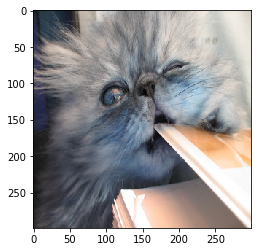

In [7]:
i = 0
plt.imshow(data[i])

The *threshold*, *p_sample* and *tau* parameters are also key to generate a sensible explanation and ensure fast enough convergence. The *threshold* defines the minimum fraction of samples for a candidate anchor that need to lead to the same prediction as the original instance. While a higher threshold gives more confidence in the anchor, it also leads to longer computation time. *p_sample* determines the fraction of superpixels that are changed to either the average value of the superpixel or the pixel value for the superimposed image. The pixels in the proposed anchors are of course unchanged. The parameter *tau* determines when we assume convergence. A bigger value for *tau* means faster convergence but also looser anchor restrictions.

In [8]:
image = images[i]
np.random.seed(0)
explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25)

Superpixels in the anchor:

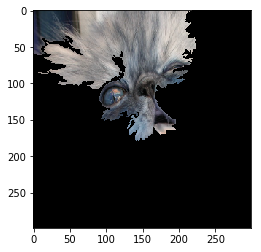

In [9]:
plt.imshow(explanation['anchor'])

A visualization of all the superpixels:

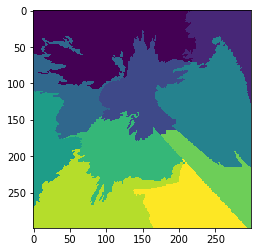

In [10]:
plt.imshow(explanation['segments'])